In [1]:
library(asreml)
library(tidyverse)
library(openxlsx)

Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 4.2.2"


No License found Fri Jan 13 11:06:57 2023


Warning message:
"package 'tidyverse' was built under R version 4.2.2"
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand()  masks Matrix::expand()
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
✖ tidyr::pack()    masks Matrix::pack()
✖ tidyr::unpack()  masks Matrix::unpack()
Warning message:
"package 'openxlsx' was built under R version 4.2.2"


### Input data

In [2]:
df_norm <- read.csv("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-归一化.csv")
df_stat <- read.csv("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-描述性统计.csv")

df_raw <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3.xlsx")
df_raw_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3.xlsx", sheet = 2)

df_ykl <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx")
df_ykl_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 2)

df_stress <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 3)
df_stress_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 4)


In [3]:
# Traits needs to be removed in V4
remove <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V4-updated-20221202.xlsx", sheet = 3)
rm_traits <- remove$Remove_Trait

update_data <- function(df, rm_traits){
    df <- df %>% select(setdiff(colnames(.) ,rm_traits))
    return(df)
}
df_raw <- update_data(df_raw, rm_traits)
df_norm <- update_data(df_norm, rm_traits)
df_ykl <- update_data(df_ykl, rm_traits)
df_stress <- update_data(df_stress, rm_traits)

df_raw_anno <- df_raw_anno %>% mutate(性状分类1 = gsub(' ', '', 性状分类1))

In [4]:
# phenotype annotation
pheno_sum <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状 - 属性解释表V2 - 李洪戈.xlsx") %>% 
    mutate(性状分类1 = gsub(' ', '', 性状分类1)) %>% 
    subset(!性状 %in% rm_traits) %>% # remove problem traits
    mutate(Treatment = ifelse(is.na(Treatment), 'BK', Treatment)) %>% 
    mutate(Develop.period = ifelse(is.na(Develop.period), 'BK', Develop.period)) %>% 
    mutate(TreatDev = paste0(Treatment, '_', Develop.period)) %>% 
    mutate(Replicate2 = ifelse(is.na(Replicate), 'R1', Replicate)) %>% 
    mutate(Replicate2 = ifelse(Trait %in% c('FW_Leaf', 'FW_Stem', 'FW_Root', 'CLAM'), 'R1', Replicate2)) %>%  # Four records have AV but no replicate, change them to R1
    subset(Replicate2 != 'AV') # remove AV records

In [5]:
# generate dimension of each trait
generate_LocYearDevRep_num <- function(pheno_sum, trait, TraitDev){
    tmp <- pheno_sum %>% subset(Trait == trait & TreatDev == TraitDev)
    Loc_num = tmp$Location %>% unique %>% length
    Year_num = tmp$Year %>% unique %>% length
    Dev_num = tmp$Develop.period %>% unique %>% length
    Rep_num = tmp$Replicate2 %>% unique %>% length
    return(c(trait, TraitDev, Loc_num, Year_num, Dev_num, Rep_num))
}

LYR_num_list <- list()
for (trait in pheno_sum$Trait %>% unique){
    for (TreatDev in pheno_sum %>% subset(Trait == trait) %>% .$TreatDev %>% unique) {
        result_vec <- generate_LocYearDevRep_num(pheno_sum, trait, TreatDev)
        LYR_num_list[[paste0(trait, '_', TreatDev)]] = result_vec
    }
}

df_LYR <- do.call(rbind, LYR_num_list) %>% 
data.frame() %>% 
mutate(numCombo = paste0(X3, X4, X6)) %>% 
setNames(c('Trait', 'TreatDev', 'Location', 'Year', 'Development', 'Replicate', 'numCombo'))

### Funcition
可以做遗传相关性状，至少要有两个records
- numCombo = 111 不能做
- 生成data后，根据T1 T2 是否都有值 判定是否向下进行
- 根据因子水平判断，生成拟合公式

In [6]:
# Combo except 111
df_LYR %>% filter(numCombo != '111') %>% dim

[1] 596   7

In [7]:
# total bi-trait comparison
(596 * 596 -596) / 2

[1] 177310

In [8]:
generate_rgp <- function(pheno_sum, df_raw, traitA, treat_devA, traitB, treat_devB){
    generate_trait_df <- function(pheno_sum, df_raw, trait, treat_dev){
        tmp <- pheno_sum %>% # generate trait info
            subset(Trait == trait & TreatDev == treat_dev) %>% 
            subset(Replicate2 != 'AV')

        tmp <- df_raw[c('ID', tmp$性状)] %>% # extract trait value
            gather(性状, value, 2:ncol(.)) %>% 
            merge(tmp, '性状') %>% 
            .[c('Trait', 'TreatDev', 'Location', 'Year', 'Replicate2', '性状', 'ID', 'value' )] %>% 
            mutate(ID = as.factor(ID)) %>% 
            mutate(Trait = paste0(Trait, '_', TreatDev)) %>% 
            mutate(Trait = as.factor(Trait)) %>% 
            mutate(Location = as.factor(Location)) %>% 
            mutate(Year = as.factor(Year)) %>% 
            mutate(TreatDev = as.factor(TreatDev)) %>% 
            mutate(Replicate2 = as.factor(Replicate2)) %>% 
            mutate(value = as.numeric(value)) %>% 
            select(-性状) %>% 
            distinct(Trait, TreatDev, Location, Year, Replicate2, ID, .keep_all = TRUE)
        return(tmp)
    }
    
    # generate input
    tmp1 <- generate_trait_df(pheno_sum, df_raw, traitA, treat_devA)
    tmp2 <- generate_trait_df(pheno_sum, df_raw, traitB, treat_devB)
    data <- rbind(tmp1, tmp2) %>% 
        pivot_wider(names_from=Trait, values_from=value) %>% 
        set_names(colnames(.) %>% .[1:5] %>% c(., 'T1', 'T2')) %>% 
        subset(!is.na(T1) & !is.na(T2))
    
    if (nrow(data) != 0){
        
    L = levels(data$Location) %>% length
    Y = levels(data$Year) %>% length
    R = levels(data$Replicate2) %>% length
    
    if (L > 1 & Y >1 & R >1){
        eq = cbind(T1, T2) ~ trait + trait:Replicate2 + trait:Location + trait:Year
    }else if (L <= 1 & Y >1 & R >1){
        eq = cbind(T1, T2) ~ trait + trait:Replicate2 + trait:Year
    }else if (L > 1 & Y <= 1 & R >1){
        eq = cbind(T1, T2) ~ trait + trait:Replicate2 + trait:Location
    }else if (L > 1 & Y > 1 & R <=1){
        eq = cbind(T1, T2) ~ trait + trait:Location + trait:Year
    }else if (L <= 1 & Y <= 1 & R >1){
        eq = cbind(T1, T2) ~ trait + trait:Replicate2
    }else if (L <= 1 & Y > 1 & R <= 1){
        eq = cbind(T1, T2) ~ trait + trait:Year
    }else if (L > 1 & Y <= 1 & R <= 1){
        eq = cbind(T1, T2) ~ trait + trait:Location
    }else{
        print(paste(paste0(traitA, "_", treat_devA), 
                    paste0(traitB, "_", treat_devB),
                    "The LocYearRep combo is 111!", 
                    sep="\t"))
    }
        
    # rgp
    require(asreml)
    mod = asreml(eq,
                random = ~ us(trait):ID,
                residual = ~ units:us(trait),
                data=data)

    mod$converge
    
    rg.vp <- vpredict(mod,rg ~ V2/sqrt(V1*V3))
    rp.vp <- vpredict(mod,rp ~ (V2+V6)/sqrt((V1+V5)*(V3+V7)))

    #遗传相关和表型相关的显著性
    moda = asreml(eq,
                random = ~ diag(trait):ID,
                residual = ~ units:us(trait),
                data=data)

    modb = asreml(eq,
                random = ~ diag(trait):ID,
                residual = ~ units:diag(trait),
                data=data)

    moda.p <- lrt.asreml(mod,moda) # 遗传相关显著性
    modb.p <- lrt.asreml(mod,modb) # 表型相关显著性

    rg.sig <- -log10(moda.p$`Pr(Chisq)`)
    rp.sig <- -log10(modb.p$`Pr(Chisq)`)

    rgp.str <- paste(paste0(traitA, "_", treat_devA), 
                     paste0(traitB, "_", treat_devB),
                     "rg", rg.vp$Estimate, rg.vp$SE, moda.p$df, moda.p$`LR-statistic`, moda.p$`Pr(Chisq)`,
                     rg.sig, 
                       "rp", rp.vp$Estimate, rp.vp$SE, modb.p$df, modb.p$`LR-statistic`, modb.p$`Pr(Chisq)`,
                     rp.sig, 
                     paste0(L, Y, R),
                       sep="\t")

    }else{
        rgp.str <- paste(paste0(traitA, "_", treat_devA), 
                         paste0(traitB, "_", treat_devB),
                         "No common records!", 
                         sep="\t")
    }
    return(rgp.str)
}

In [ ]:
# test for loop run
test <- df_LYR %>% filter(numCombo != '111') %>% head
test

trait_vec <- test$Trait
treatdev_vec <- test$TreatDev
trait_num <- nrow(test)

for (i in 1:(trait_num - 1)) {
    for (j in (i + 1):trait_num) {
        print(paste(trait_vec[i], treatdev_vec[i], "---", trait_vec[j], treatdev_vec[j]))
        result <- generate_rgp(pheno_sum, df_raw, trait_vec[i], treatdev_vec[i],
            trait_vec[j], treatdev_vec[j])
        cat(result, file = "./ASreml_results/test_out.txt", append = T, sep = "\n")
    }
}

#### 1st run all

In [ ]:
# # run all results
# test <- df_LYR %>% filter(numCombo != '111') 

# trait_vec <- test$Trait
# treatdev_vec <- test$TreatDev
# trait_num <- nrow(test)

# for (i in 1:(trait_num - 1)) {
#     for (j in (i + 1):trait_num) {
#         tryCatch({
#             print(paste(trait_vec[i], treatdev_vec[i], "---", trait_vec[j], treatdev_vec[j]))
#             result <- generate_rgp(pheno_sum, df_raw, trait_vec[i], treatdev_vec[i],
#                 trait_vec[j], treatdev_vec[j])
#             cat(result, file = "./ASreml_results/run_all_25Dec2022.txt", append = T, sep = "\n")
#         }, error = function(e) {
#             cat("ERROR :", conditionMessage(e), "")
#         })
#     }
# }

##### Result analysis and visual

In [46]:
require(pheatmap)

In [2]:
df_trait_class <- pheno_sum %>% 
    mutate(TraitID = paste0(Trait, '_', TreatDev)) %>% 
    .[c('性状分类1', 'TraitID')] %>% 
    distinct()

ERROR: Error in mutate(., TraitID = paste0(Trait, "_", TreatDev)): object 'pheno_sum' not found


In [3]:
df_result <- read.table("./ASreml_results/run_all_25Dec2022.txt", sep='\t', header = F, fill=T) %>% 
    set_names(c("Trait1", "Trait2", "rg", "rg_Estimate", "rg_SE", "rg_df", "rg_LR-statistic", "rg_Pr(Chisq)", "rg_sig",
                "rp", "rp_Estimate", "rp_SE", "rp_df", "rp_LR-statistic", "rp_Pr(Chisq)", "rp_sig", "LYR_combo"))

In [7]:
df_result %>% filter(!is.na(rg_Estimate)) %>% write.csv("./ASreml_results/genetic_and_phenotypic_correlation.csv", row.names=F)

##### rG results

In [80]:
df_yes <- df_result %>% filter(!is.na(rg_Estimate))%>% 
    filter(`rg_Pr(Chisq)` < 0.05)

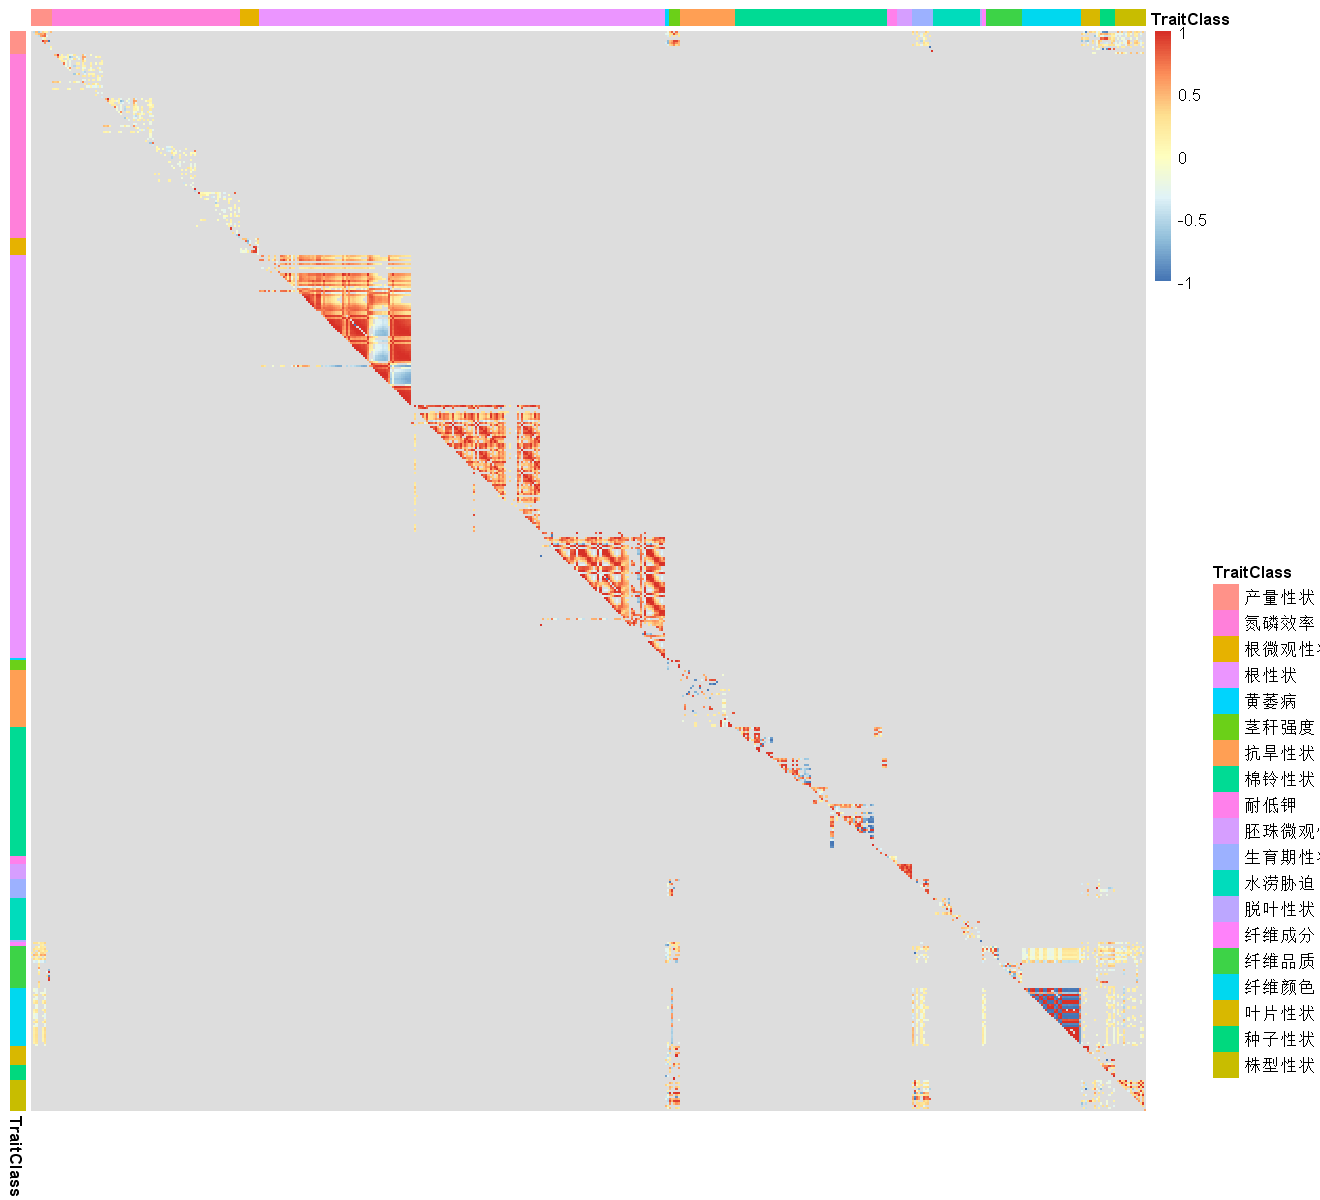

In [56]:
rG_matrix <- df_yes[c('Trait1', 'Trait2', 'rg_Estimate')] %>% 
    pivot_wider(names_from=Trait2, values_from=rg_Estimate) %>% 
    column_to_rownames('Trait1')

plot_pheatmap <- function(df, df_trait_class){
    trait_order <- df_trait_class %>% arrange(性状分类1) %>% .$TraitID
    
    ordered_row = setdiff(trait_order, setdiff(trait_order, rownames(df)))
    ordered_col = setdiff(trait_order, setdiff(trait_order, colnames(df)))
    data = df[ordered_row,  ordered_col]
    
    row_trait_class <- df_trait_class %>% subset(TraitID %in% rownames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1
    col_trait_class <- df_trait_class %>% subset(TraitID %in% colnames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1

    annotation_row <- data.frame(TraitClass = row_trait_class)
    rownames(annotation_row) <- ordered_row
    annotation_col <- data.frame(TraitClass = col_trait_class)
    rownames(annotation_col) <- ordered_col
    
    require(pheatmap)
    options(repr.plot.width = 11, repr.plot.height = 10)
    p <- data %>% 
        pheatmap(cluster_rows = FALSE,
                 cluster_cols = FALSE,
                 annotation_row = annotation_row,
                 annotation_col = annotation_col,
                 fontsize = 10,
                 show_rownames = F, 
                 show_colnames = F)
    return(p)
}

plot_pheatmap(rG_matrix, df_trait_class)

In [69]:
data <- df_yes %>% 
    merge(df_trait_class, by.x = 'Trait1', by.y = 'TraitID') %>% 
    setNames(c(colnames(.)[1:(ncol(.)-1)], 'Trait_class_1')) %>% 
    merge(df_trait_class, by.x = 'Trait2', by.y = 'TraitID') %>% 
    setNames(c(colnames(.)[1:(ncol(.)-1)], 'Trait_class_2'))

In [100]:
plot_rG <- function(data, TRAIT){
    data %>% 
    subset(Trait_class_1 == TRAIT | Trait_class_2 == TRAIT) %>% 
    mutate(vs_trait = ifelse(Trait_class_2 == TRAIT, Trait_class_1, Trait_class_2)) %>% 
    ggplot(aes(x=vs_trait, y=rg_Estimate)) + 
        geom_violin() + 
        geom_jitter(width = 0.2, alpha = 0.5, color = 'grey30')+
        xlab(paste(TRAIT, 'vs 以上性状类别')) +
        ylab('rG') +
        theme_classic() +
        theme(axis.text.y = element_text(size = 15),
              axis.text.x = element_text(size = 15, angle = 45, hjust=1, vjust=1),
              axis.title = element_text(size = 20),
              axis.title.x  = element_text(size = 20),
              legend.text = element_text(size = 15),
              legend.title = element_text(size = 15),
              plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm')) -> p
    return(p)
    }

Warning message:
"Groups with fewer than two data points have been dropped."


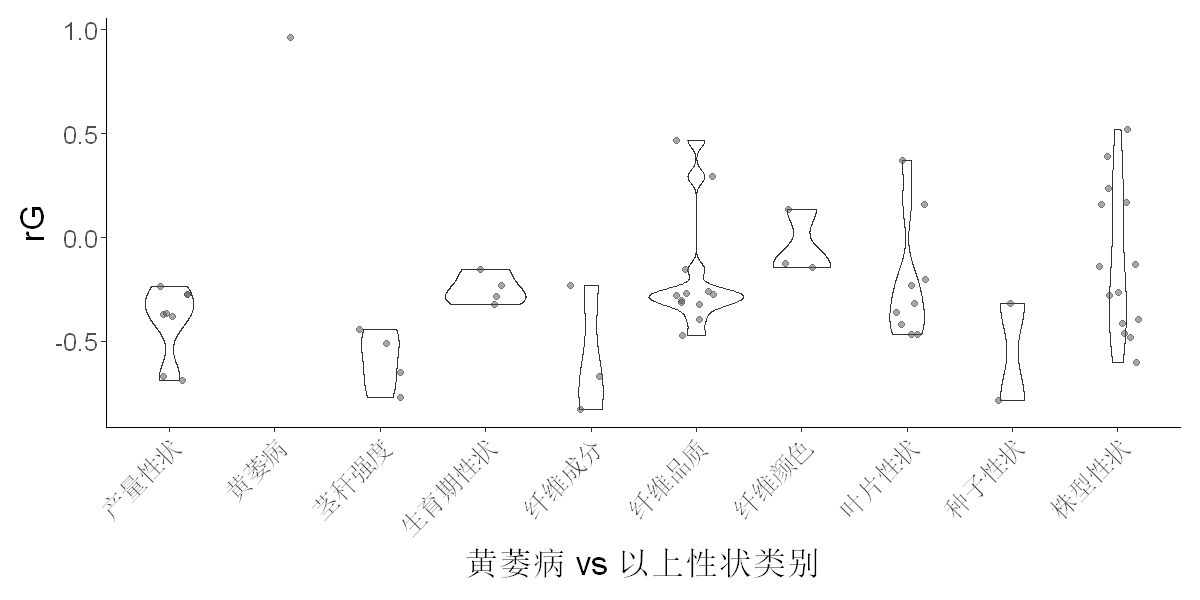

In [101]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot_rG(data, '黄萎病')

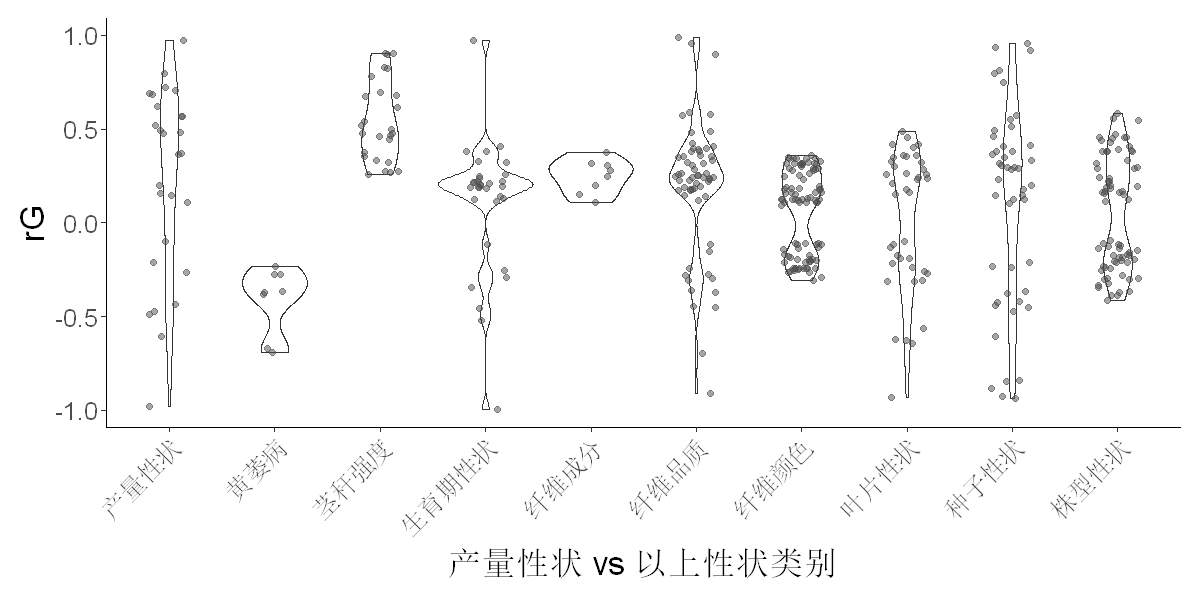

In [102]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot_rG(data, '产量性状')

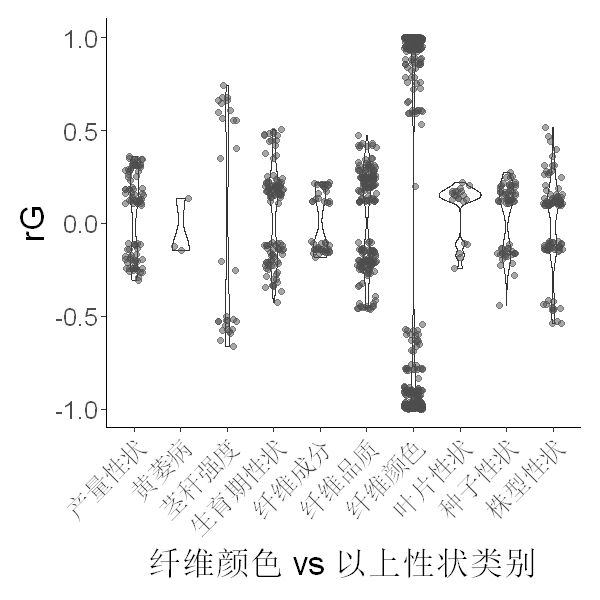

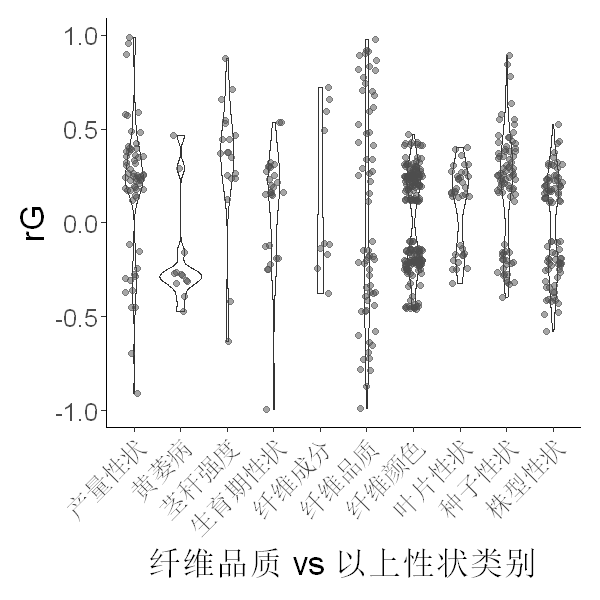

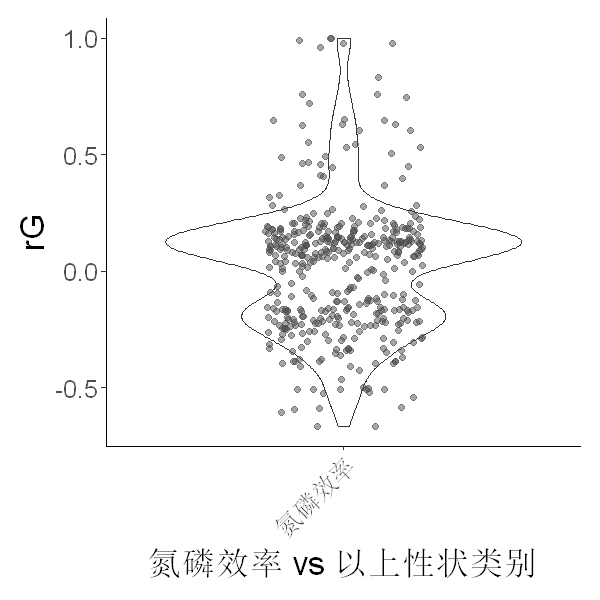

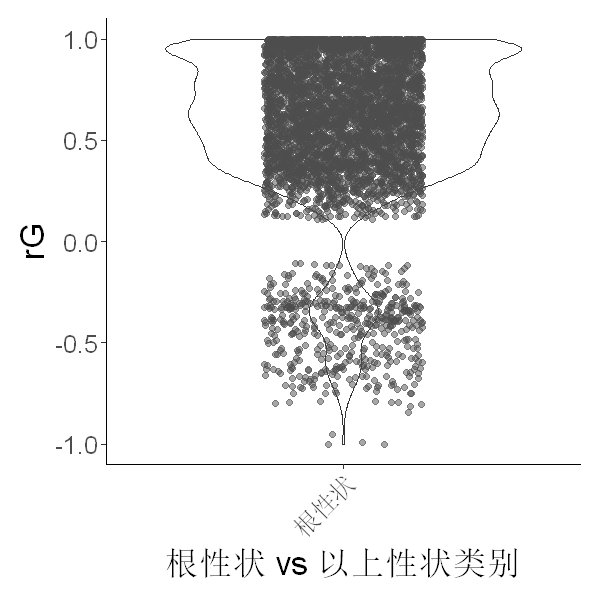

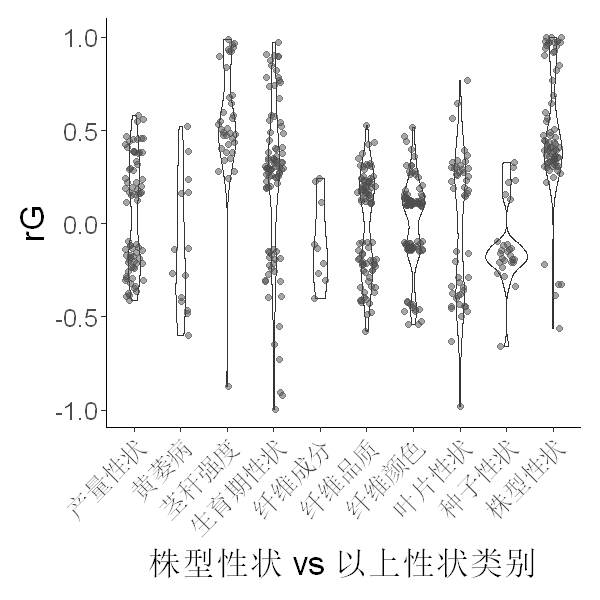

Warning message:
"Groups with fewer than two data points have been dropped."


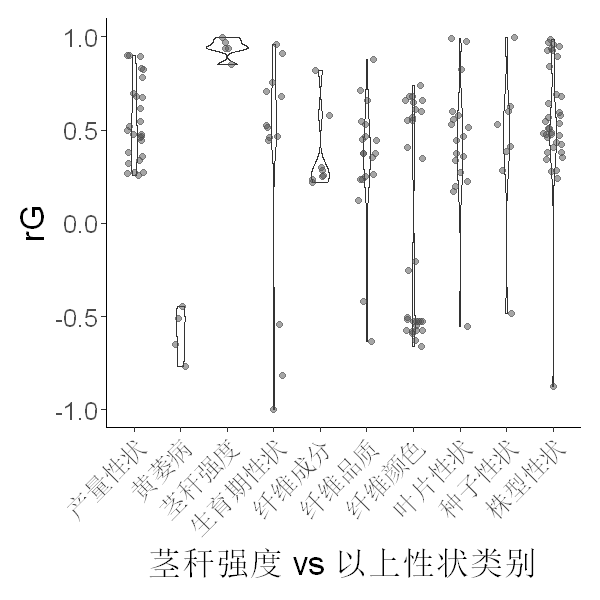

Warning message:
"Groups with fewer than two data points have been dropped."


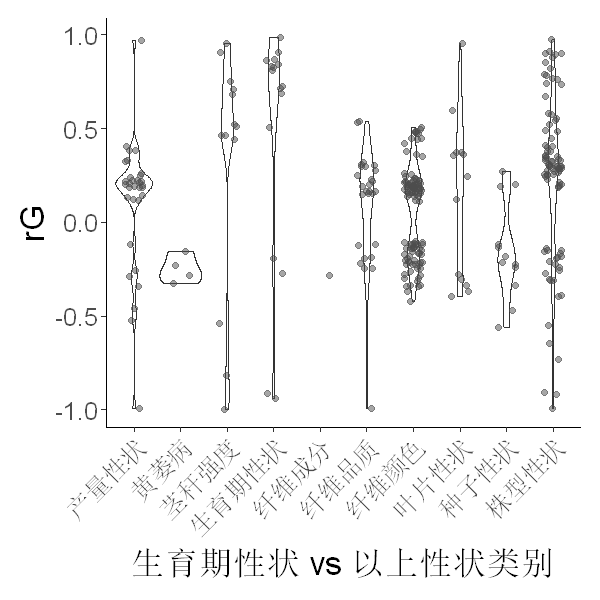

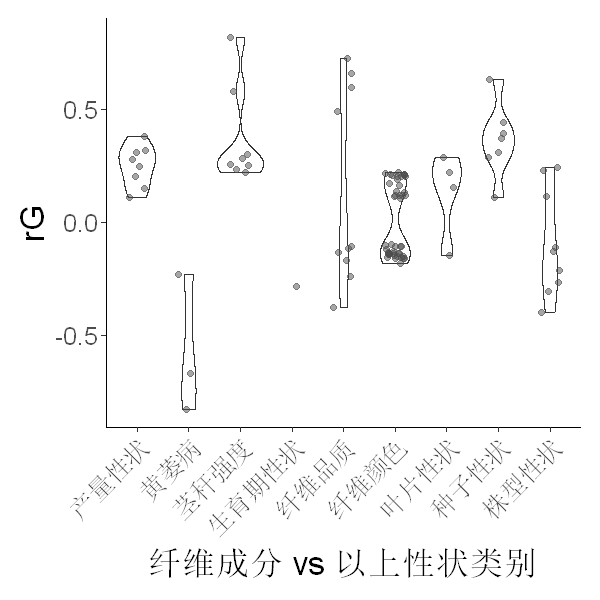

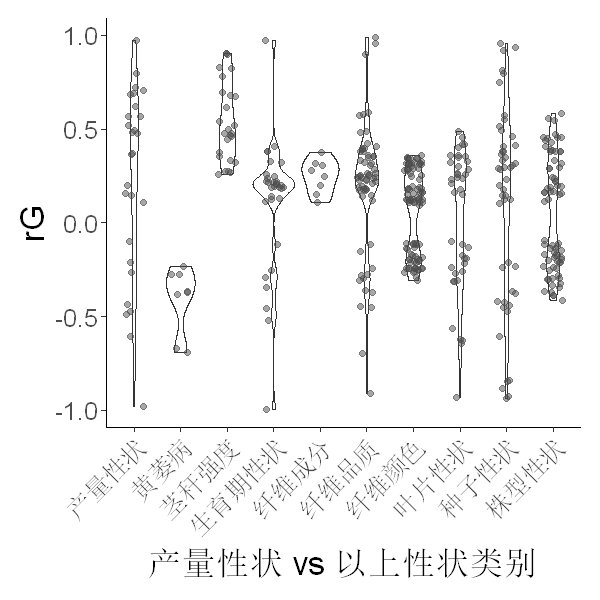

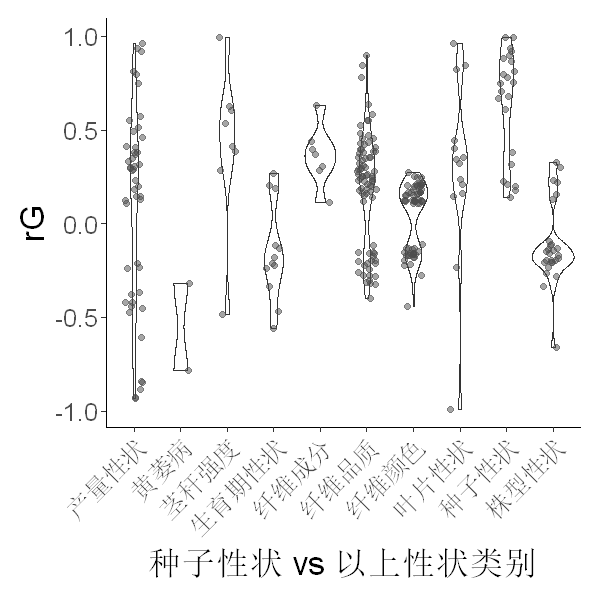

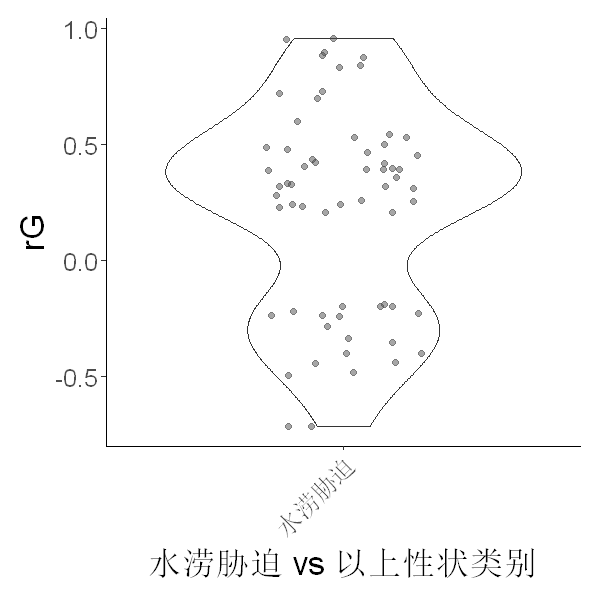

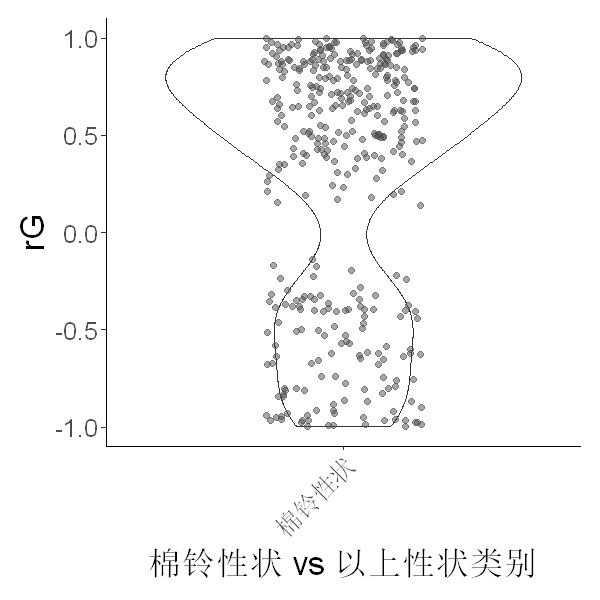

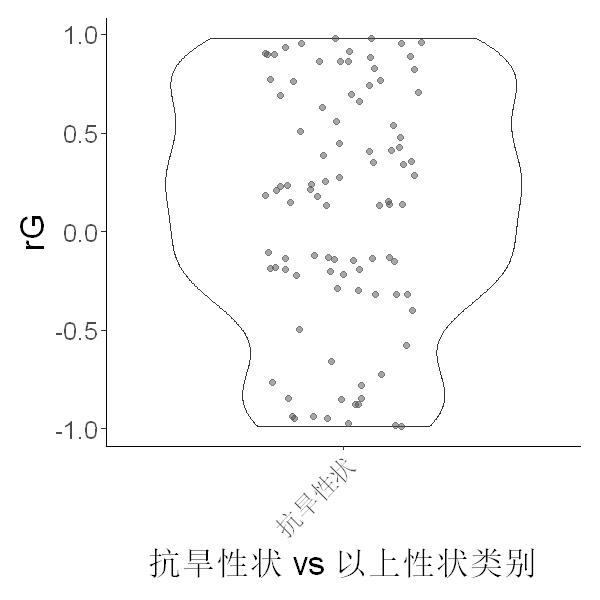

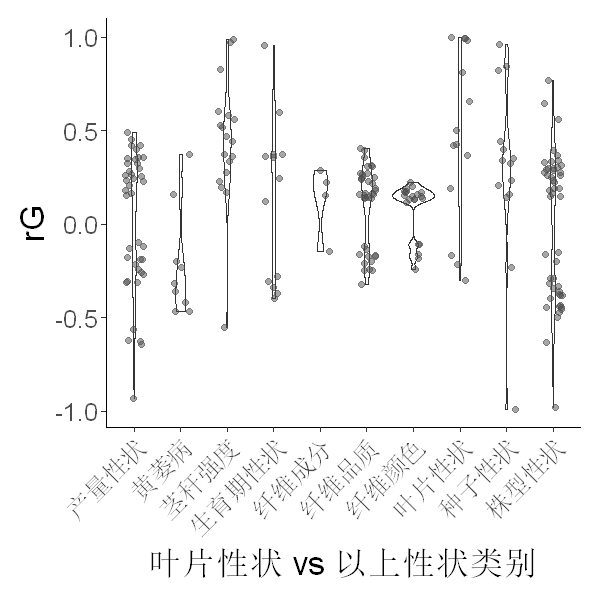

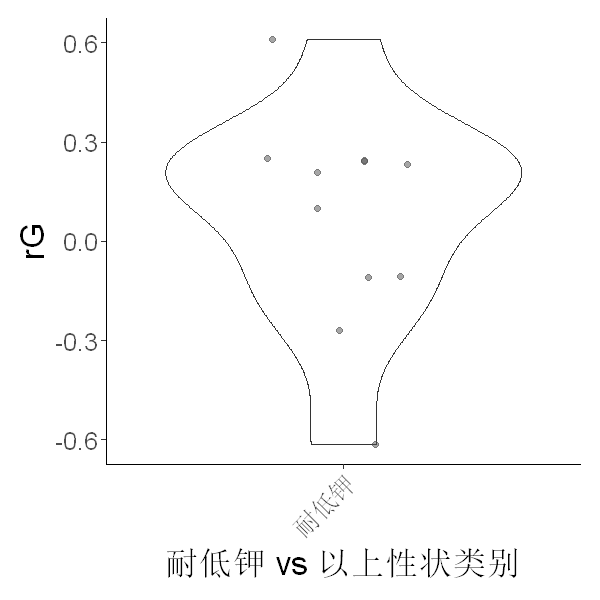

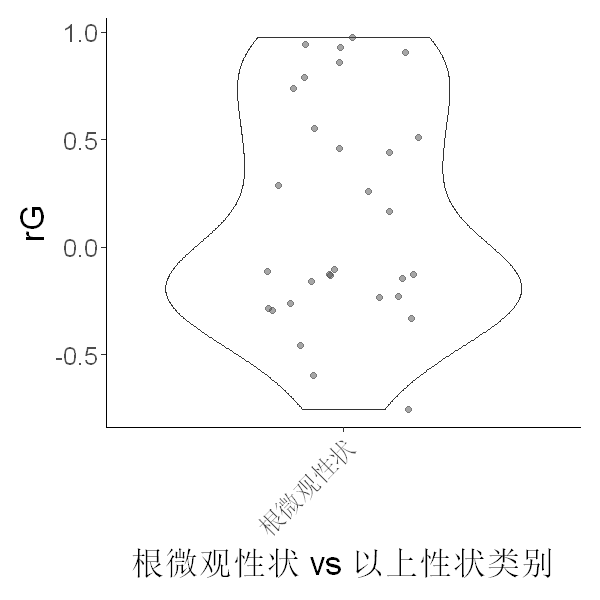

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(data$density):
"no non-missing arguments to max; returning -Inf"
Warning message:
"Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0"


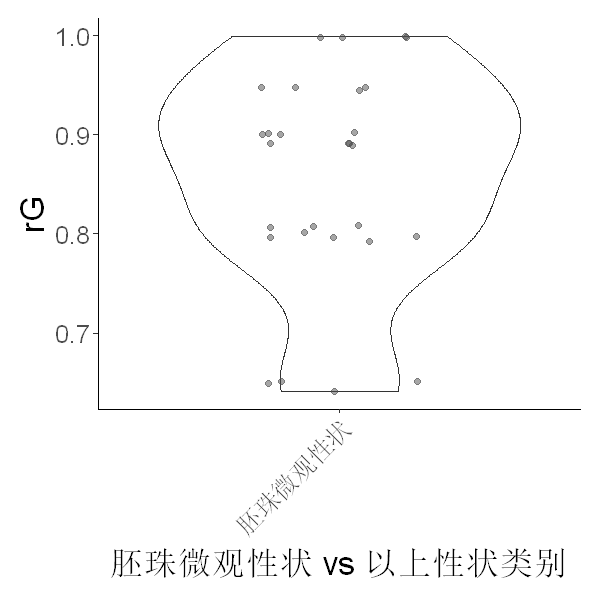

Warning message:
"Groups with fewer than two data points have been dropped."


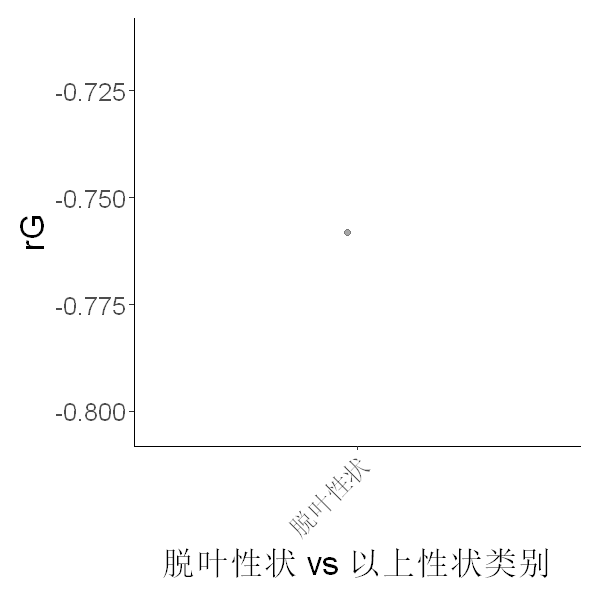

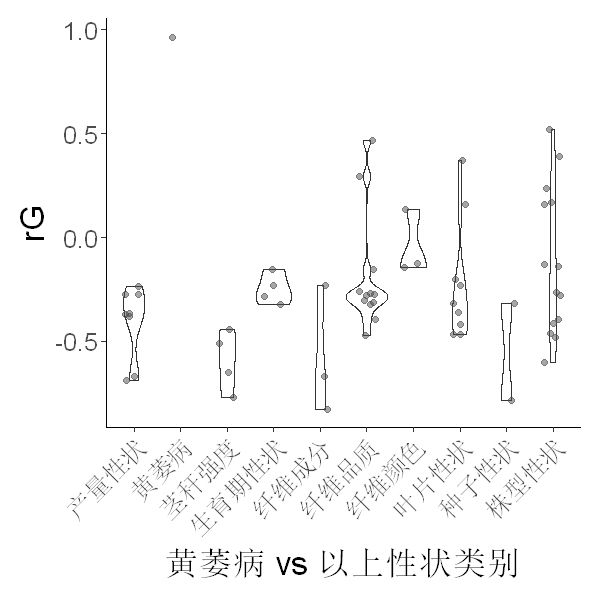

In [106]:
options(repr.plot.width = 5, repr.plot.height = 5)
for (i in data$Trait_class_1 %>% unique){
    p <- plot_rG(data, i)
    print(p)
}

##### rP results

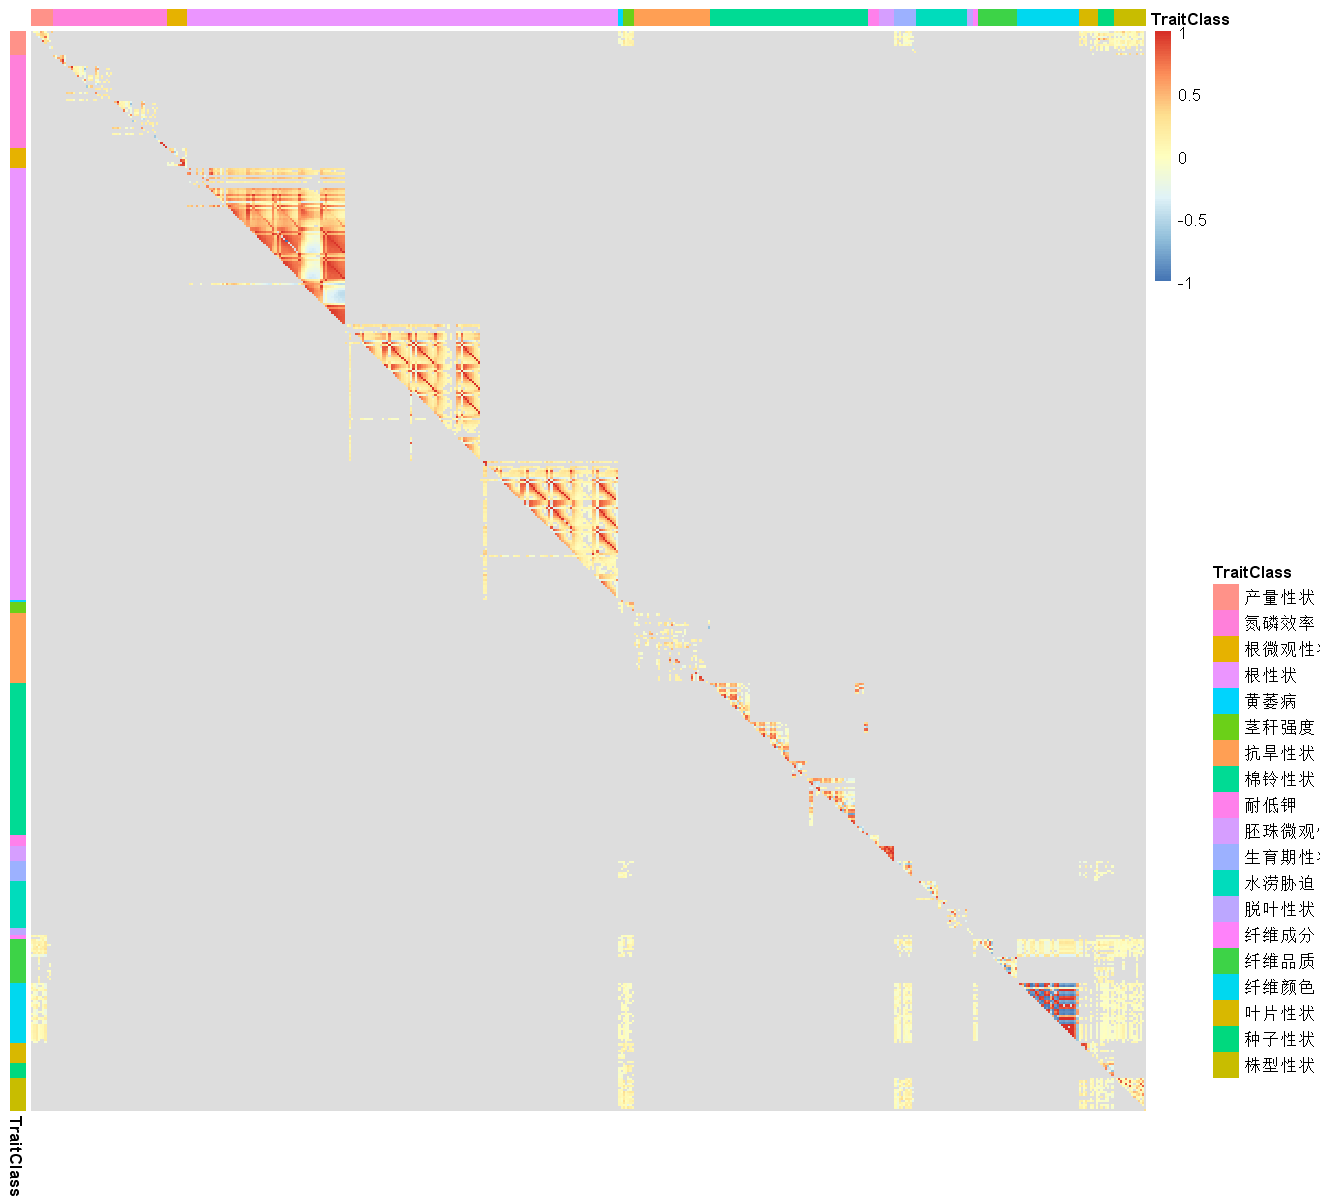

In [61]:
df_yes <- df_result %>% filter(!is.na(rp_Estimate) )%>% 
    filter(`rp_Pr(Chisq)` < 0.05)

rP_matrix <- df_yes[c('Trait1', 'Trait2', 'rp_Estimate')] %>% 
    pivot_wider(names_from=Trait2, values_from=rp_Estimate) %>% 
    column_to_rownames('Trait1')

plot_pheatmap <- function(df, df_trait_class){
    trait_order <- df_trait_class %>% arrange(性状分类1) %>% .$TraitID
    
    ordered_row = setdiff(trait_order, setdiff(trait_order, rownames(df)))
    ordered_col = setdiff(trait_order, setdiff(trait_order, colnames(df)))
    data = df[ordered_row,  ordered_col]
    
    row_trait_class <- df_trait_class %>% subset(TraitID %in% rownames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1
    col_trait_class <- df_trait_class %>% subset(TraitID %in% colnames(df)) %>% distinct(TraitID, .keep_all = T) %>% arrange(性状分类1) %>% .$性状分类1

    annotation_row <- data.frame(TraitClass = row_trait_class)
    rownames(annotation_row) <- ordered_row
    annotation_col <- data.frame(TraitClass = col_trait_class)
    rownames(annotation_col) <- ordered_col
    
    require(pheatmap)
    options(repr.plot.width = 11, repr.plot.height = 10)
    p <- data %>% 
        pheatmap(cluster_rows = FALSE,
                 cluster_cols = FALSE,
                 annotation_row = annotation_row,
                 annotation_col = annotation_col,
                 fontsize = 10,
                 show_rownames = F, 
                 show_colnames = F)
    return(p)
}

plot_pheatmap(rP_matrix, df_trait_class)